## Project 1 Hotdog -- no hotdog
This project is a simple web application that uses a convolutional neural network (CNN) model to classify images as "hotdog" or "not hotdog". 

In [12]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [13]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [14]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='data/hotdog_nothotdog/hotdog_nothotdog'):  # Update this path
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]

        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y
    


Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [15]:
size = 128  # Keep your original size or change to 224 as in your example

# ENHANCED: Training transforms with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip horizontally
    transforms.RandomRotation(degrees=15),    # Rotate by up to 15 degrees
    transforms.ColorJitter(
        brightness=0.1,    # ±20% brightness variation
        contrast=0.1,      # ±20% contrast variation
    ),
    transforms.RandomResizedCrop(size, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Center at 0.5 for each RGB channel
                        std=[0.5, 0.5, 0.5])     # Scale to [-1, 1] range
])

# Keep test transforms simple (no augmentation for testing)
test_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Center at 0.5 for each RGB channel
                        std=[0.5, 0.5, 0.5])     # Scale to [-1, 1] range
])
batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)  # Changed to 0
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)  # Changed to 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.827451].


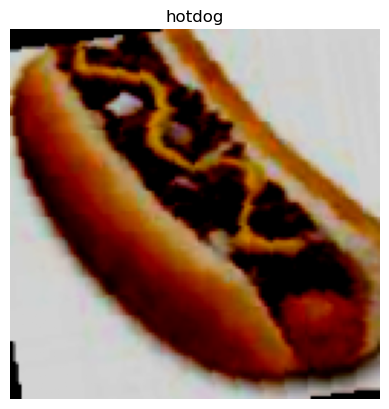

In [16]:
# Show a sample image from the trainset after transform to check for distortion
img, label = trainset[0]
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.title(['hotdog', 'not hotdog'][label])
plt.axis('off')
plt.show()

How much data do we have by default? Do we need to augment it?

In [17]:
train_image_count = len(train_loader.dataset)
test_image_count = len(test_loader.dataset)

print(f"Number of training images: {train_image_count}")
print(f"Number of test images: {test_image_count}")

Number of training images: 2047
Number of test images: 1862


Let's look at some images from our data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.77254903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.70980394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping in

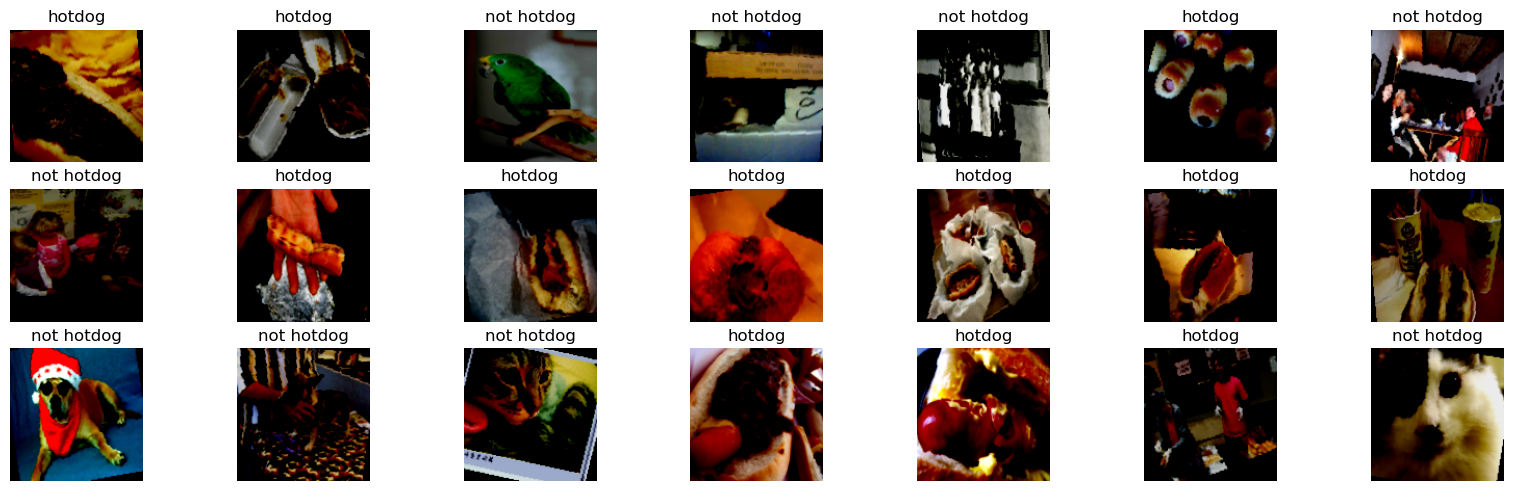

In [18]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


Inspiration from lectures:
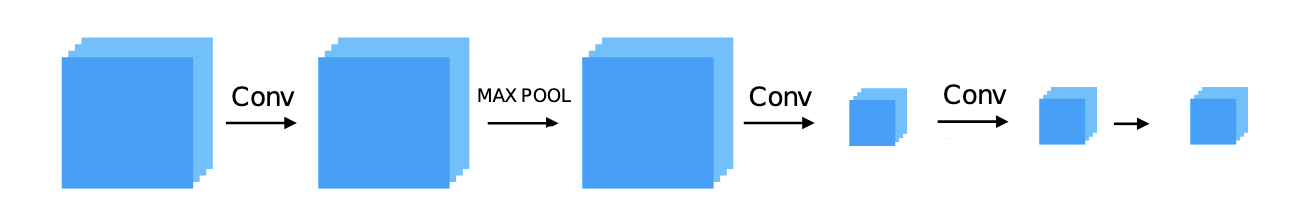

Thoughts regarding the architecture:
- to conv -> maxpool -> to conv -> FC
- Binary classification (needs to be reduced to one output).
- Hot-dog images are in RGB, meaning it has 3 channels

Layer 1 (convolutional):
- Here, kernel size is 3x3, and the stride and padding are both one, to retain the dimensionality of the images.
- First convolution captures basic structures, while the second convolution learns more complex and non-linear structures.
- Maxpooling 2x2 with a stride of 2 is performed. This is to half the size of the image so 128x128 -> 64x64. Makes the model generalise better, and less computational.
- Third convolution has kernel size of 3x3, with stride and padding of 1. This layer increases channels, such that the detail is greater. Fourth convolution captures non-linearies from the maxpooled size.
- This structure has inspired from what has been discussed in lectures, and uses the receptive field in order to remember the structure in later layers.

Layer 2 (Fully connected)
- Firstly, the layer converts the feature maps to one long vector per image. This is because the fully-connected network requires a vector.
- The change from 16*64*64 to 128 and through ReLU makes the information learned compact, and this because the linear combination on which the classifier predicts.
- Finally, the 128 neurons are passed through only two neurons, either hotdog or no-hotdog.

Additional comments:
- Because we used CrossEntropyLoss, it was not relevant to apply an activation function to the end result.

In [19]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
            # First block: 32 filters
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128x128 -> 64x64

            # Second block: 64 filters
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64 -> 32x32

            # Third block: 128 filters
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)   # 32x32 -> 16x16
        )

        self.fully_connected = nn.Sequential(
            nn.Flatten(),  # Alternative to x.view() in forward
            nn.Linear(128 * 16 * 16, 128),  # 128 channels * 16 * 16 = 32,768
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),  # Single output for binary classification
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

    def forward(self, x):
        x = self.convolutional(x)
        x = self.fully_connected(x)
        return x

In [20]:
model = Network()
model.to(device)

# Use Adam optimizer with lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Get the first minibatch - FIXED: use device instead of .cuda()
data = next(iter(train_loader))[0].to(device)
# Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
model(data)  # if this runs the model dimensions fit

Shape of the output from the convolutional part torch.Size([64, 128, 16, 16])


tensor([[0.5889],
        [0.5093],
        [0.4316],
        [0.5125],
        [0.3860],
        [0.5694],
        [0.6079],
        [0.7730],
        [0.5318],
        [0.5843],
        [0.6193],
        [0.6615],
        [0.4486],
        [0.4321],
        [0.4467],
        [0.6201],
        [0.4789],
        [0.4687],
        [0.4761],
        [0.6331],
        [0.6093],
        [0.5149],
        [0.6444],
        [0.5273],
        [0.6484],
        [0.4645],
        [0.6391],
        [0.5718],
        [0.3548],
        [0.5092],
        [0.5739],
        [0.3440],
        [0.4907],
        [0.5866],
        [0.4443],
        [0.6148],
        [0.4493],
        [0.4870],
        [0.6408],
        [0.4673],
        [0.5283],
        [0.6060],
        [0.5366],
        [0.4757],
        [0.4663],
        [0.6744],
        [0.4038],
        [0.6392],
        [0.4951],
        [0.5810],
        [0.4778],
        [0.4805],
        [0.5190],
        [0.4803],
        [0.4950],
        [0

Training and testing of the model


In [21]:
num_epochs = 5  # Increased for better training
criterion = nn.BCELoss()  # Made for binary classification, Binary Cross Entropy for sigmoid output

for epoch in tqdm(range(num_epochs), unit='epoch'):
    model.train()  # Set training mode
    train_correct = 0
    train_loss = 0
    
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        
        # FIXED: Convert target to float and reshape for BCELoss
        target = target.float().unsqueeze(1)  # Shape: [batch_size, 1]
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Compute the loss
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()

        # FIXED: Compute accuracy for binary classification with sigmoid
        predicted = (output > 0.5).float()  # Threshold at 0.5
        train_correct += (target == predicted).sum().item()
        train_loss += loss.item()
    
    # FIXED: Test evaluation
    model.eval()  # Set evaluation mode
    test_correct = 0
    with torch.no_grad():  # Disable gradients for evaluation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target = target.float().unsqueeze(1)  # Same conversion for test
            
            output = model(data)
            predicted = (output > 0.5).float()  # Threshold at 0.5
            test_correct += (target == predicted).sum().item()
    
    # Calculate accuracies
    train_acc = train_correct / len(trainset)
    test_acc = test_correct / len(testset)
    avg_loss = train_loss / len(train_loader) 
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Loss: {avg_loss:.4f}")  
    print(f"Accuracy - Train: {train_acc*100:.1f}%\t Test: {test_acc*100:.1f}%")
    print("-" * 50)

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/5
Loss: 1.0670
Accuracy - Train: 67.7%	 Test: 65.6%
--------------------------------------------------


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/5
Loss: 0.5768
Accuracy - Train: 73.4%	 Test: 73.9%
--------------------------------------------------


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/5
Loss: 0.5310
Accuracy - Train: 76.7%	 Test: 74.1%
--------------------------------------------------


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/5
Loss: 0.4790
Accuracy - Train: 78.0%	 Test: 75.6%
--------------------------------------------------


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/5
Loss: 0.4721
Accuracy - Train: 78.1%	 Test: 76.9%
--------------------------------------------------


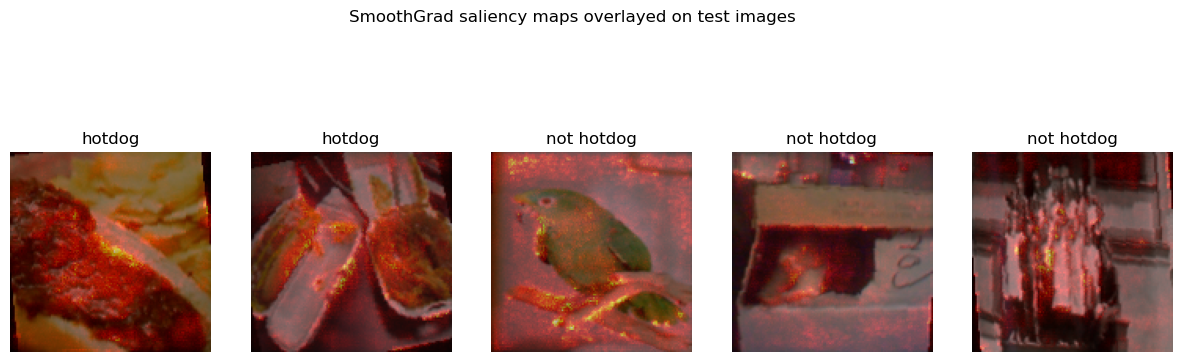

In [22]:
# SmoothGrad parameters
num_samples = 25  # Number of noisy samples per image
noise_std = 0.15  # Standard deviation of noise (relative to input range)

model.eval()
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    img = images[i].unsqueeze(0)
    img = img.to(device)
    img_np = img.detach().cpu().numpy()
    smooth_saliency = np.zeros_like(img_np)

    for _ in range(num_samples):
        # Add noise
        noise = torch.randn_like(img) * noise_std
        noisy_img = img + noise
        noisy_img.requires_grad_()

        output = model(noisy_img)
        score = output[0, 0]
        model.zero_grad()
        score.backward()

        # Get saliency map for this noisy image
        saliency = noisy_img.grad.data.abs().cpu().numpy()
        smooth_saliency += saliency

    # Average the saliency maps
    smooth_saliency /= num_samples
    smooth_saliency = smooth_saliency.squeeze()
    # Take max over channels
    smooth_saliency = np.max(smooth_saliency, axis=0)
    # Normalize for visualization
    smooth_saliency = (smooth_saliency - smooth_saliency.min()) / (smooth_saliency.max() - smooth_saliency.min() + 1e-8)

    # Prepare image for display (unnormalize)
    img_disp = img.squeeze().detach().cpu().numpy()
    img_disp = np.transpose(img_disp, (1, 2, 0))
    img_disp = img_disp * 0.5 + 0.5  # Undo normalization to [0,1]

    axes[i].imshow(img_disp)
    axes[i].imshow(smooth_saliency, cmap='hot', alpha=0.5)
    axes[i].set_title(['hotdog', 'not hotdog'][int(labels[i].item())])
    axes[i].axis('off')

plt.suptitle("SmoothGrad saliency maps overlayed on test images")
plt.show()